# Tugas Besar A
IF3270 Pembelajaran Mesin<br>
Forward Propagation - Feed Forward Neural Network (FFNN)

Developed by:
1. K01 13520010 - Ken Kalang Al Qalyubi
2. K01 13520036 - I Gede Arya Raditya Parameswara
3. K02 13520061 - Gibran Darmawan
4. K03 13520119 - Marchotridyo

## Main Program

### Library

In [161]:
import json, math
import networkx as nx
import matplotlib.pyplot as plt
from enum import Enum

### Enum

In [162]:
class LayerEnum(Enum):
    INPUT = "input"
    HIDDEN = "hidden"
    OUTPUT = "output"

class ActivationFuncEnum(Enum):
    SIGMOID = "sigmoid"
    LINEAR = "linear"
    RELU = "relu"
    SOFTMAX = "softmax"

### File Utility

In [163]:
class FileUtility:
    @staticmethod
    def import_json(file_name):
        with open(file_name) as json_file:
            return json.load(json_file)

    @staticmethod
    def export_json(file_name, data):
        with open(file_name, 'w') as outfile:
            json.dump(data, outfile)

### Layer

In [164]:
class Layer:
    # Layer adalah kelas yang menyimpan sejumlah neutron berikut fungsi aktivasinya
    def __init__(self, neurons: list, type: str, activation_func: str):
        self.__neurons = neurons
        self.__type = type
        self.__activation_func = activation_func

    def add_neuron(self, neuron):
        self.__neurons.append(neuron)

    def get_neurons(self):
        return self.__neurons
    
    def get_type(self):
        return self.__type
    
    def get_activation_func(self):
        return self.__activation_func

### Neuron

In [165]:
class Neuron:
    def __init__(
        self, 
        layer: Layer,
        weight: list
    ):
        self.__layer: Layer = layer
        self.__weight: list = weight
        self.__bias: list = 1
        self.__net: float = 0.0
        self.__value: float = 0.0

    def activate(self):
        if self.__layer.get_activation_func() == ActivationFuncEnum.SIGMOID.value:
            self.__value = 1 / (1 + math.exp(-self.__net))
        elif self.__layer.get_activation_func() == ActivationFuncEnum.LINEAR.value:
            self.__value = self.__net
        elif self.__layer.get_activation_func() == ActivationFuncEnum.RELU.value:
            self.__value = max(0, self.__net)
        elif self.__layer.get_activation_func() == ActivationFuncEnum.SOFTMAX.value:
            layer_neurons: list = self.__layer.get_neurons()
            exp_sum: float = 0.0

            for neuron in layer_neurons:
                exp_sum += math.exp(neuron.get_net())

            self.__value = math.exp(self.__net) / exp_sum

    def set_value(self, value):
        self.__value = value

    def set_net(self, net):
        self.__net = net

    def get_value(self):
        return self.__value

    def get_net(self):
        return self.__net
    
    def get_weight(self, index):
        return self.__weight[index]

    def get_bias(self):
        return self.__bias

### ANN Graph

In [166]:
class ANNGraph:
    def __init__(self, file_config_path: str):
        self.file_path = file_config_path
        self.config = None

        self.layers: list[Layer] = []
        self.build_ann_graph()

    def build_ann_graph(self):
        self.config = FileUtility.import_json(self.file_path)

        # Buat input layer
        input_layer = Layer([], LayerEnum.INPUT.value, "")
        input_size = self.config["case"]["model"]["input_size"]
        for _ in range(input_size):
            neuron = self.__generate_neuron_data(input_layer, {"weights": []})
            input_layer.add_neuron(neuron)
        self.layers.append(input_layer)

        layers = self.config["case"]["model"]["layers"]

        for i, layer in enumerate(layers):
            # Untuk setiap layer, persiapkan neuronnya
            layer_type = LayerEnum.HIDDEN.value
            if i == len(layers) - 1:
                layer_type = LayerEnum.OUTPUT.value
            
            curr_layer = Layer([], layer_type, layer["activation_function"])

            layer_weights = self.config["case"]["weights"][i]

            for j in range(layer["number_of_neurons"]):
                neuron_weights = []
                for k in range(len(layer_weights)):
                    neuron_weights.append(layer_weights[k][j])
                neuron = self.__generate_neuron_data(curr_layer, {"weights": neuron_weights})
                curr_layer.add_neuron(neuron)

            self.layers.append(curr_layer)

        return
    
    def draw_ann_graph(self):
        # Terminologies:
        # Xi = neuron ke-i di input layer
        # Hij = neuron ke-j di hidden layer ke-i
        # Oi = neuron ke-i di output layer

        G = nx.DiGraph()

        # Proses setiap layer
        for i, layer in enumerate(self.layers):
            if i == 0:
                continue

            prev_layer = self.layers[i - 1]
            prev_prefix = ""
            prefix = ""

            if prev_layer.get_type() == LayerEnum.INPUT.value:
                prev_prefix = "X"
            elif prev_layer.get_type() == LayerEnum.HIDDEN.value:
                prev_prefix = f"H{i - 1}"
            else:
                prev_prefix = "O"
            
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"

            # Tambahkan edge dari setiap neuron di prev_layer ke layer
            for j, _ in enumerate(prev_layer.get_neurons()):
                for k, neuron in enumerate(layer.get_neurons()):
                    if j == 0:
                        print(f"Bobot bias untuk {prefix}{k + 1} = {neuron.get_weight(0)}")
                    G.add_edge(f"{prev_prefix}{j + 1}", f"{prefix}{k + 1}", weight=neuron.get_weight(j + 1))
            
        # Set posisi node graph
        pos = {}
        curr_x = 0
        for i, layer in enumerate(self.layers):
            curr_y = 0

            prefix = ""
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"
            
            for j, _ in enumerate(layer.get_neurons()):
                pos[f"{prefix}{j + 1}"] = (curr_x, curr_y)
                curr_y += 1

            curr_x += 1

        options = {
            "font_size": 12,
            "node_size": 2000,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 5,
            "width": 5,
        }

        nx.draw_networkx(G, pos, **options)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels, label_pos=0.6)

        ax = plt.gca()
        ax.margins(0.2)
        plt.axis("off")
        plt.show()

    def predict(self, input_data):
        for i in range(len(input_data)):
            # Masukkan input_data ke neuron di input layer
            neuron: Neuron = self.layers[0].get_neurons()[i]
            neuron.set_value(input_data[i])

        self.__activate_all_neurons()

        return

    def print_details(self):
        for i, layer in enumerate(self.layers):
            print("--------------------")
            print(f"Layer {i+1} ({layer.get_type()})")
            if layer.get_type() != LayerEnum.INPUT.value:
                print(f"Activation function: {layer.get_activation_func()}")
            print("--------------------")
            if layer.get_type() != LayerEnum.INPUT.value:
                for j, neuron in enumerate(layer.get_neurons()):
                    print(f"[Neuron {j+1}] Net:", neuron.get_net())
                    print(f"[Neuron {j+1}] Value:", neuron.get_value())
            else:
                for j, neuron in enumerate(layer.get_neurons()):
                    print(f"[Neuron {j+1}] is supplied value of {neuron.get_value()}")
            print("")

    def __generate_neuron_data(self, layer: Layer, neuron_data):
        weights: list = []

        if (layer.get_type() == LayerEnum.HIDDEN.value or layer.get_type() == LayerEnum.OUTPUT.value):
            weights = neuron_data["weights"]

        return Neuron(layer, weights)
    
    def __activate_all_neurons(self):
        for i, layer in enumerate(self.layers):
            if layer.get_type() == LayerEnum.INPUT.value:
                continue # Tidak perlu activate untuk input layer

            previous_layer = self.layers[i - 1]
            
            # Hitung dulu masing-masing netnya, baru dihitung valuenya
            for neuron in layer.get_neurons():
                self.__calculate_neuron_net(neuron, previous_layer)
    
            for neuron in layer.get_neurons():
                neuron.activate()
        return

    def __calculate_neuron_net(self, neuron: Neuron, previous_layer: Layer):
        total = 0.0

        for i, prev_neuron in enumerate(previous_layer.get_neurons()):
            # i + 1 karena i = 0 adalah weight dari bias
            total += prev_neuron.get_value() * neuron.get_weight(i + 1)

        total += neuron.get_bias() * neuron.get_weight(0)

        neuron.set_net(total)

    def solve(self):
        output = []
        inputs = self.config["case"]["input"]
        expected_output = self.config["expect"]["output"]
        max_sse = self.config["expect"]["max_sse"]

        for _input in inputs:
            print(f">> Untuk input {_input}")
            self.predict(_input)
            self.print_details()
            # Bentuk output matrix
            last_layer = self.layers[len(self.layers) - 1]
            last_layer_neurons = last_layer.get_neurons()
            output_arr = []
            for neuron in last_layer_neurons:
                output_arr.append(neuron.get_value())
            output.append(output_arr)
        
        print(f">> Output: {output}")

        # Calculate SSE
        sse = 0
        for i in range(len(output)):
            for j in range(len(output[i])):
             sse += (output[i][j] - expected_output[i][j]) ** 2

        print(f">> SSE with expected output: {sse}")
        print(f">> max_sse = {max_sse}")

## Testing

### Linear

Bobot bias untuk O1 = 0.2
Bobot bias untuk O2 = 0.3
Bobot bias untuk O3 = 0.1


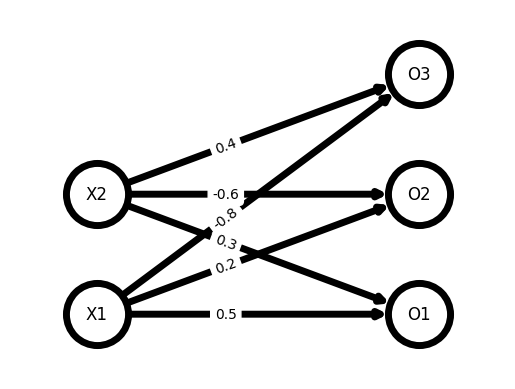

>> Untuk input [3.0, 1.0]
--------------------
Layer 1 (input)
--------------------
[Neuron 1] is supplied value of 3.0
[Neuron 2] is supplied value of 1.0

--------------------
Layer 2 (output)
Activation function: linear
--------------------
[Neuron 1] Net: 2.0
[Neuron 1] Value: 2.0
[Neuron 2] Net: 0.3000000000000001
[Neuron 2] Value: 0.3000000000000001
[Neuron 3] Net: -1.9000000000000004
[Neuron 3] Value: -1.9000000000000004

>> Output: [[2.0, 0.3000000000000001, -1.9000000000000004]]
>> SSE with expected output: 2.0954117794933126e-31 || max_sse = 1e-06


In [167]:
graph = ANNGraph("config/linear.json")
graph.draw_ann_graph()
graph.solve()

### ReLu

Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.2
Bobot bias untuk O3 = 0.3


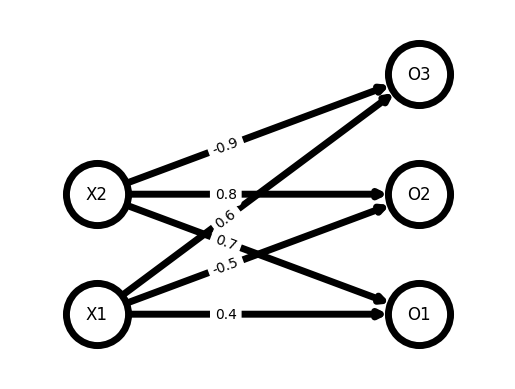

>> Untuk input [-1.0, 0.5]
--------------------
Layer 1 (input)
--------------------
[Neuron 1] is supplied value of -1.0
[Neuron 2] is supplied value of 0.5

--------------------
Layer 2 (output)
Activation function: relu
--------------------
[Neuron 1] Net: 0.04999999999999996
[Neuron 1] Value: 0.04999999999999996
[Neuron 2] Net: 1.1
[Neuron 2] Value: 1.1
[Neuron 3] Net: -0.75
[Neuron 3] Value: 0

>> Output: [[0.04999999999999996, 1.1, 0]]
>> SSE with expected output: 1.7333369499485123e-33 || max_sse = 1e-06


In [168]:
graph = ANNGraph("config/relu.json")
graph.draw_ann_graph()
graph.solve()

### Sigmoid

Bobot bias untuk O1 = 0.4
Bobot bias untuk O2 = 0.2
Bobot bias untuk O3 = 0.1


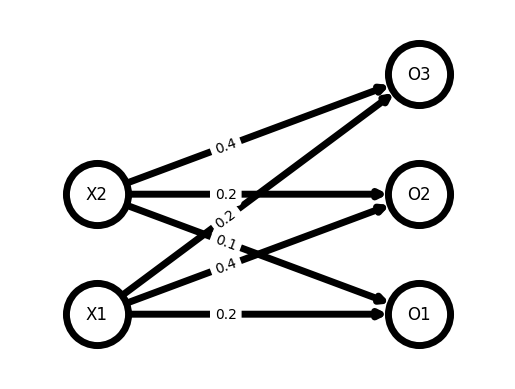

>> Untuk input [0.2, 0.4]
--------------------
Layer 1 (input)
--------------------
[Neuron 1] is supplied value of 0.2
[Neuron 2] is supplied value of 0.4

--------------------
Layer 2 (output)
Activation function: sigmoid
--------------------
[Neuron 1] Net: 0.48000000000000004
[Neuron 1] Value: 0.617747874769249
[Neuron 2] Net: 0.36000000000000004
[Neuron 2] Value: 0.5890404340586651
[Neuron 3] Net: 0.30000000000000004
[Neuron 3] Value: 0.574442516811659

>> Output: [[0.617747874769249, 0.5890404340586651, 0.574442516811659]]


IndexError: list index out of range

In [169]:
graph = ANNGraph("config/sigmoid.json")
graph.draw_ann_graph()
graph.solve()

### Softmax

Bobot bias untuk O1 = 1.0
Bobot bias untuk O2 = 2.0
Bobot bias untuk O3 = 3.0


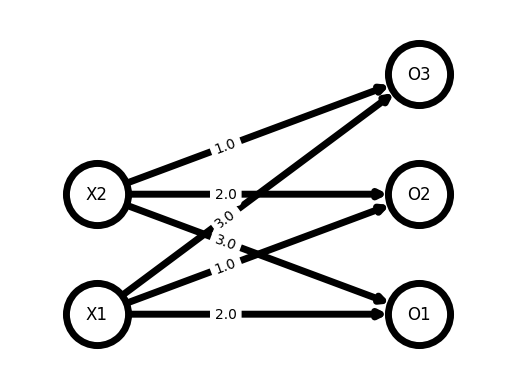

>> Untuk input [1.0, 2.0]
--------------------
Layer 1 (input)
--------------------
[Neuron 1] is supplied value of 1.0
[Neuron 2] is supplied value of 2.0

--------------------
Layer 2 (output)
Activation function: softmax
--------------------
[Neuron 1] Net: 9.0
[Neuron 1] Value: 0.6652409557748219
[Neuron 2] Net: 7.0
[Neuron 2] Value: 0.09003057317038045
[Neuron 3] Net: 8.0
[Neuron 3] Value: 0.24472847105479764

>> Output: [[0.6652409557748219, 0.09003057317038045, 0.24472847105479764]]


In [ ]:
graph = ANNGraph("config/softmax.json")
graph.draw_ann_graph()
graph.solve()

### Multilayer

Bobot bias untuk H11 = 0.5
Bobot bias untuk H12 = 0.5
Bobot bias untuk O1 = 0.5
Bobot bias untuk O2 = 0.5


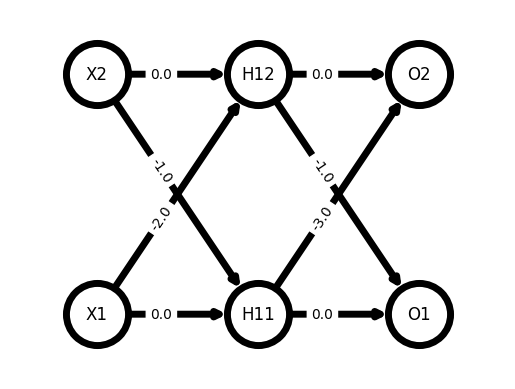

>> Untuk input [1.0, 0.0]
--------------------
Layer 1 (input)
--------------------
[Neuron 1] is supplied value of 1.0
[Neuron 2] is supplied value of 0.0

--------------------
Layer 2 (hidden)
Activation function: linear
--------------------
[Neuron 1] Net: 0.5
[Neuron 1] Value: 0.5
[Neuron 2] Net: -1.5
[Neuron 2] Value: -1.5

--------------------
Layer 3 (output)
Activation function: relu
--------------------
[Neuron 1] Net: 2.0
[Neuron 1] Value: 2.0
[Neuron 2] Net: -1.0
[Neuron 2] Value: 0

>> Untuk input [0.0, 1.0]
--------------------
Layer 1 (input)
--------------------
[Neuron 1] is supplied value of 0.0
[Neuron 2] is supplied value of 1.0

--------------------
Layer 2 (hidden)
Activation function: linear
--------------------
[Neuron 1] Net: -0.5
[Neuron 1] Value: -0.5
[Neuron 2] Net: 0.5
[Neuron 2] Value: 0.5

--------------------
Layer 3 (output)
Activation function: relu
--------------------
[Neuron 1] Net: 0.0
[Neuron 1] Value: 0
[Neuron 2] Net: 2.0
[Neuron 2] Value: 2.0

>

In [ ]:
graph = ANNGraph("config/multilayer.json")
graph.draw_ann_graph()
graph.solve()